In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, mean_absolute_percentage_error, explained_variance_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [2]:
df = pd.read_csv("/home/aditya/flask/ml/dataset/open-meteo-18.62N74.00E561m.csv")
df['date_time'] = pd.to_datetime(df['time'])

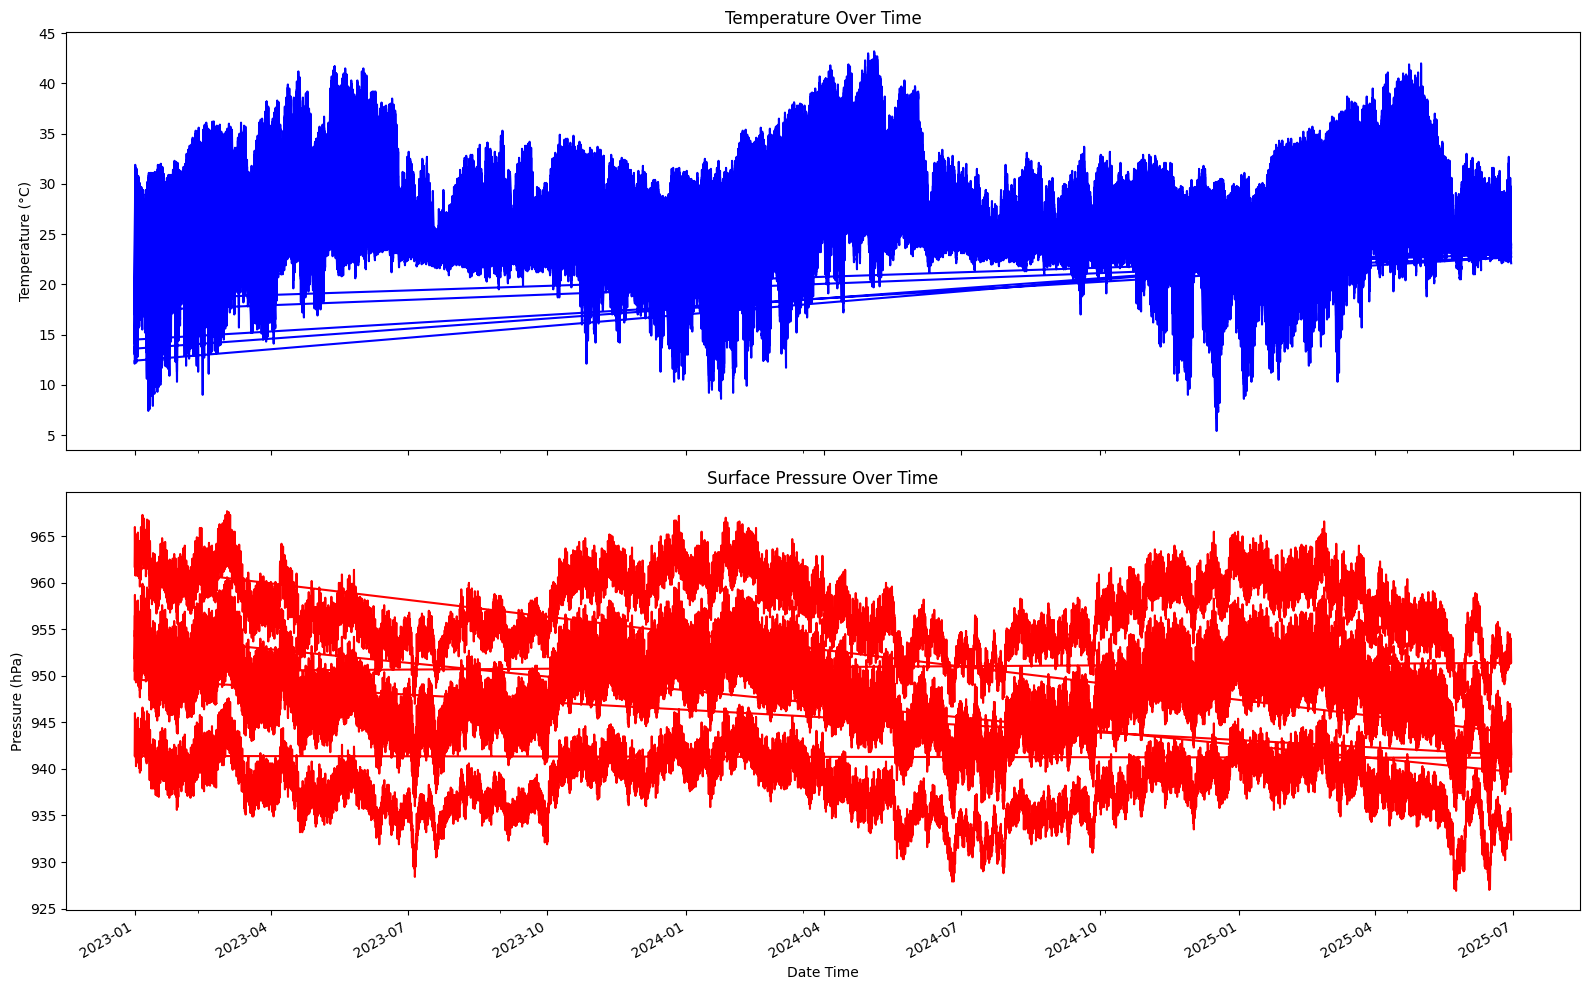

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
df.plot(x='date_time', y='temperature_2m (°C)', ax=axes[0], color='blue', legend=False)
axes[0].set_title("Temperature Over Time")
axes[0].set_ylabel("Temperature (°C)")
df.plot(x='date_time', y='surface_pressure (hPa)', ax=axes[1], color='red', legend=False)
axes[1].set_title("Surface Pressure Over Time")
axes[1].set_ylabel("Pressure (hPa)")
axes[1].set_xlabel("Date Time")
plt.tight_layout()
plt.show()

In [4]:
def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("Reject the null hypothesis — data is STATIONARY.")
    else:
        print("Fail to reject the null hypothesis — data is NOT stationary.")
adfuller_test(df['temperature_2m (°C)'])

ADF Statistic: -10.66115448728148
p-value: 4.403769950696858e-19
# Lags Used: 73
# Observations Used: 131110
Reject the null hypothesis — data is STATIONARY.


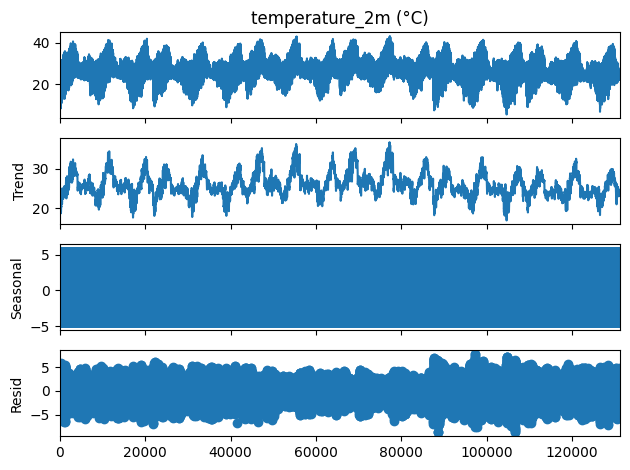

In [5]:
result = seasonal_decompose(df['temperature_2m (°C)'], model='additive', period=24)
result.plot()
plt.show()

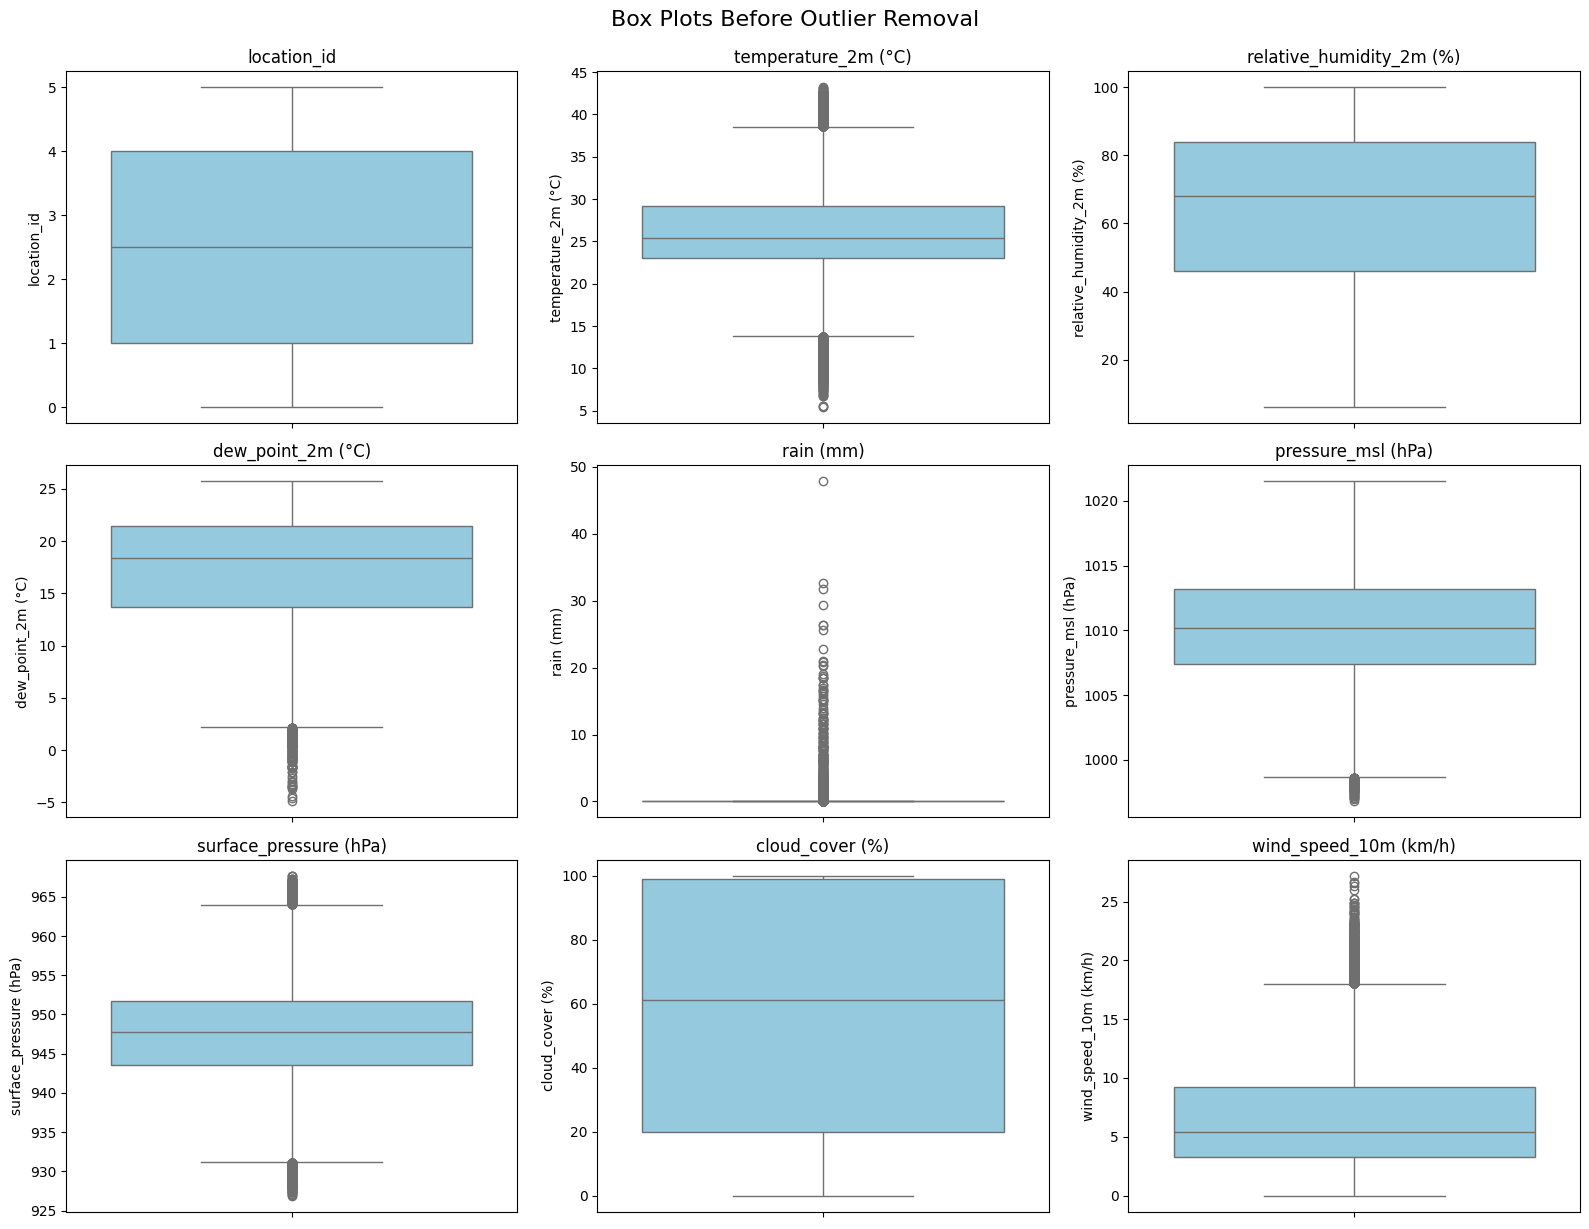

In [6]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Box Plots Before Outlier Removal", fontsize=16, y=1.02)
plt.show()

In [7]:
def remove_outliers_iqr(df, exclude_columns=[]):
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_columns]
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

df_cleaned = remove_outliers_iqr(df, exclude_columns=['location_id'])

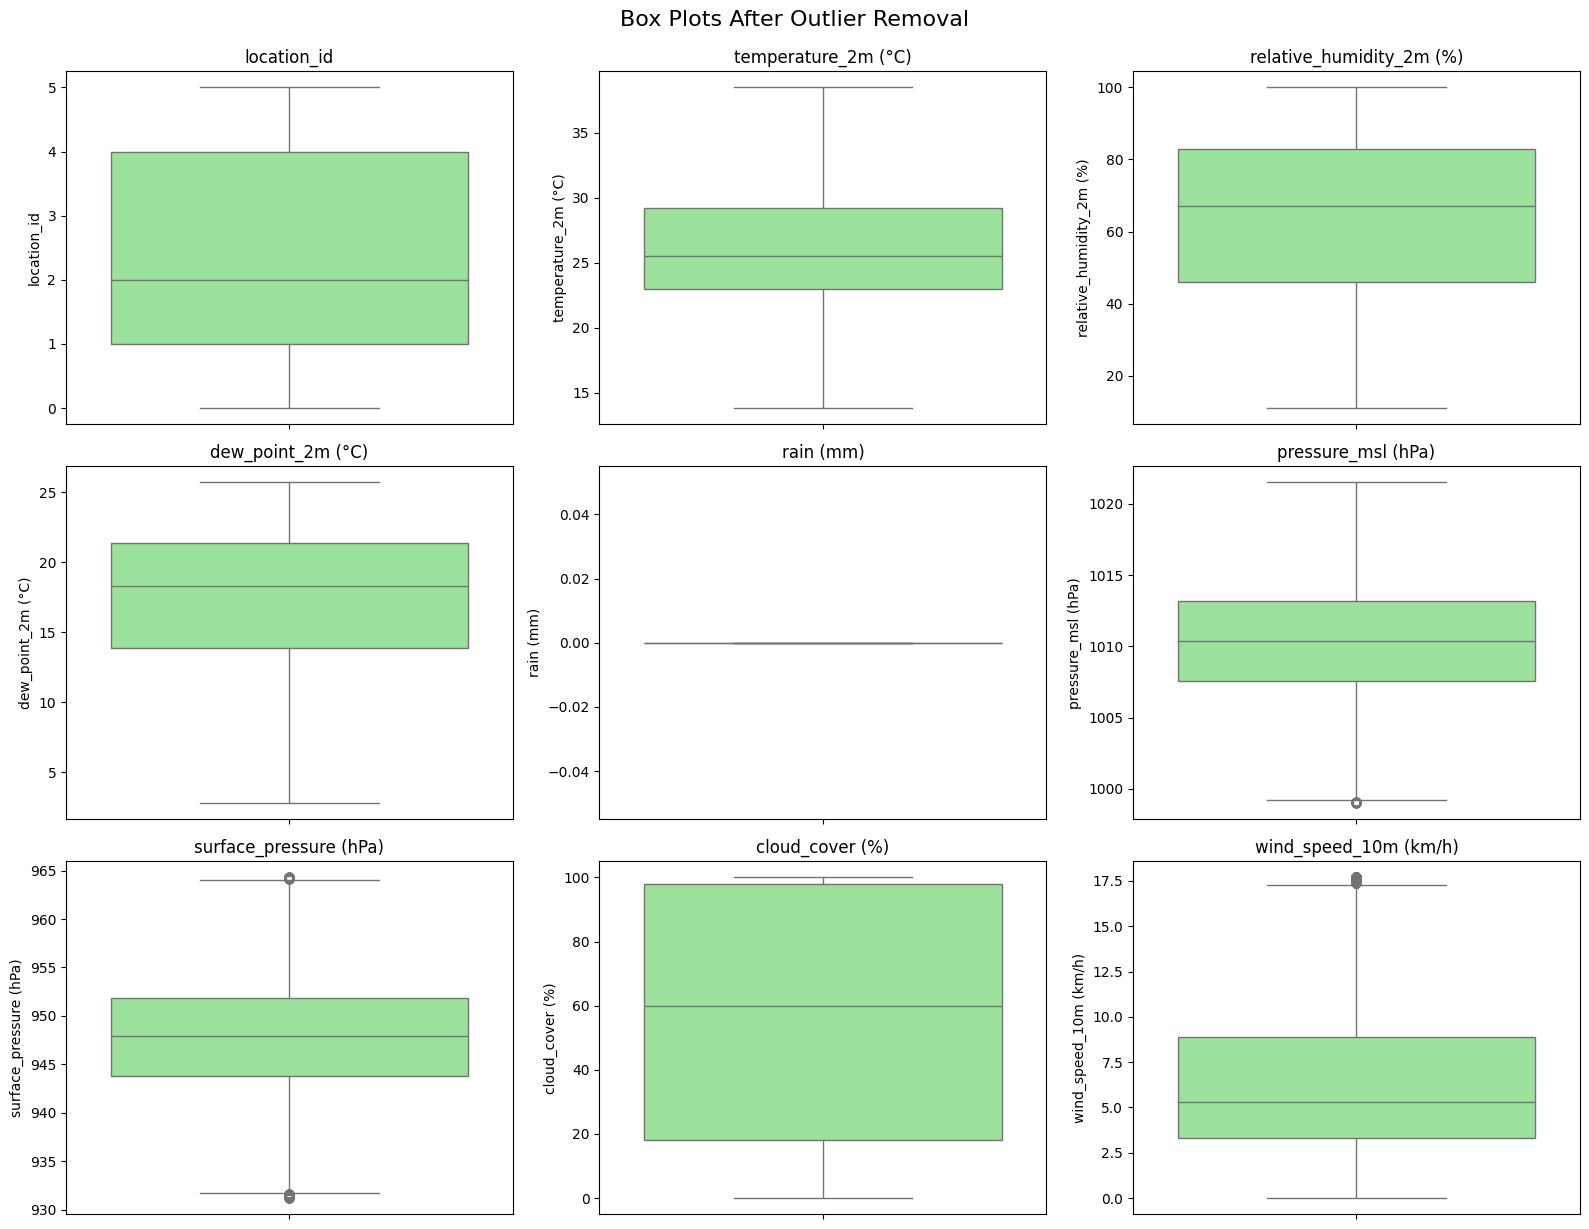

In [8]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((len(numeric_cols) + 2) // 3, 3, i)
    sns.boxplot(y=df_cleaned[col], color='lightgreen')
    plt.title(col)
    plt.tight_layout()
plt.suptitle("Box Plots After Outlier Removal", fontsize=16, y=1.02)
plt.show()

In [9]:
columns_to_scale = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
columns_to_scale = [col for col in columns_to_scale if col not in ['location_id']]
scaler = MinMaxScaler()
df_scaled = df_cleaned.copy()
df_scaled[columns_to_scale] = scaler.fit_transform(df_cleaned[columns_to_scale])

In [10]:
df_scaled['hour'] = df_scaled['date_time'].dt.hour
df_scaled['dayofweek'] = df_scaled['date_time'].dt.dayofweek
df_scaled['month'] = df_scaled['date_time'].dt.month

df_scaled['sin_hour'] = np.sin(2 * np.pi * df_scaled['hour'] / 24)
df_scaled['cos_hour'] = np.cos(2 * np.pi * df_scaled['hour'] / 24)
df_scaled['sin_dayofweek'] = np.sin(2 * np.pi * df_scaled['dayofweek'] / 7)
df_scaled['cos_dayofweek'] = np.cos(2 * np.pi * df_scaled['dayofweek'] / 7)
df_scaled['sin_month'] = np.sin(2 * np.pi * df_scaled['month'] / 12)
df_scaled['cos_month'] = np.cos(2 * np.pi * df_scaled['month'] / 12)

In [11]:
def create_supervised_with_location_and_features(df, target_col, feature_cols, window=24):
    features, targets = [], []
    grouped = df.groupby('location_id')
    for loc, group in grouped:
        group = group.sort_values('date_time')
        for i in range(window, len(group)):
            window_data = group.iloc[i-window:i][feature_cols].values.flatten()
            location_feature = [loc]
            full_features = np.concatenate((window_data, location_feature))
            y = group.iloc[i][target_col]
            features.append(full_features)
            targets.append(y)
    return np.array(features), np.array(targets)

In [12]:
feature_cols = ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
                'rain (mm)', 'pressure_msl (hPa)', 'surface_pressure (hPa)',
                'cloud_cover (%)', 'wind_speed_10m (km/h)',
                'sin_hour', 'cos_hour', 'sin_dayofweek', 'cos_dayofweek', 'sin_month', 'cos_month']

In [13]:
X, y = create_supervised_with_location_and_features(df_scaled, target_col='temperature_2m (°C)', feature_cols=feature_cols, window=24)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [24]:
print("x_train shape : ",X_train.shape)
print("x_test shape : ",X_test.shape)
print("y_train shape : ",y_train.shape)
print("y_test shape : ",y_test.shape)

x_train shape :  (97963, 337)
x_test shape :  (24491, 337)
y_train shape :  (97963,)
y_test shape :  (24491,)


In [15]:
param_dist = {
    'n_estimators': [10, 30, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

base_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(base_model, param_distributions=param_dist,
                                   n_iter=20, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_train, y_train)
model = random_search.best_estimator_

In [18]:
print(f"[INFO] Best Parameters: {random_search.best_params_}")

[INFO] Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}


In [19]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
evs = explained_variance_score(y_test, y_pred)

print("\n--- Model Performance (Generalized with Additional Features) ---")
print(f"Mean Absolute Error (MAE)         : {mae:.4f}")
print(f"Mean Squared Error (MSE)          : {mse:.4f}")
print(f"Root Mean Squared Error (RMSE)    : {rmse:.4f}")
print(f"R² Score                          : {r2:.4f}")
print(f"Median Absolute Error (MedAE)     : {medae:.4f}")
print(f"Mean Absolute Percentage Error    : {mape:.4f}")
print(f"Explained Variance Score (EVS)    : {evs:.4f}")



--- Model Performance (Generalized with Additional Features) ---
Mean Absolute Error (MAE)         : 0.0228
Mean Squared Error (MSE)          : 0.0011
Root Mean Squared Error (RMSE)    : 0.0328
R² Score                          : 0.9729
Median Absolute Error (MedAE)     : 0.0162
Mean Absolute Percentage Error    : 358792827672.5693
Explained Variance Score (EVS)    : 0.9730


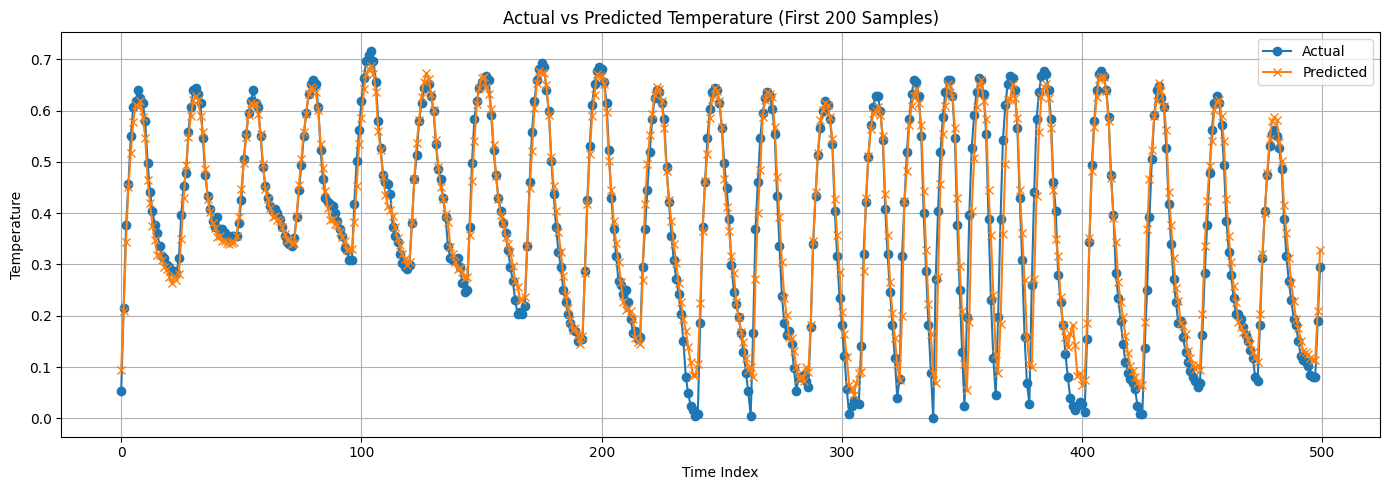

In [22]:
# STEP 15: Plot Actual vs Predicted
plt.figure(figsize=(14,5))
plt.plot(y_test[:500], label='Actual', marker='o')
plt.plot(y_pred[:500], label='Predicted', marker='x')
plt.title("Actual vs Predicted Temperature (First 200 Samples)")
plt.ylabel("Temperature")
plt.xlabel("Time Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
importances = model.feature_importances_
feature_names = [f"{col}_{i}" for i in range(24) for col in feature_cols] + ["location_id"]
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False).head(20)


,Feature,Importance
322,temperature_2m (°C)_23,0.080987
14,temperature_2m (°C)_1,0.066424
308,temperature_2m (°C)_22,0.055658
302,sin_hour_21,0.052377
288,sin_hour_20,0.047435
0,temperature_2m (°C)_0,0.046062
294,temperature_2m (°C)_21,0.040048
134,sin_hour_9,0.034939
274,sin_hour_19,0.030591
205,cos_hour_14,0.027952


In [17]:
# Temperature Forecasting Data Preprocessing and Modeling Pipeline
# ---------------------------------------------------------------

# STEP 1: Import libraries


# STEP 2: Load and inspect data


# STEP 3: Initial time series plots


# STEP 4: ADF Test for Stationarity


# STEP 5: Seasonal Decomposition


# STEP 6: Boxplot to Detect Outliers


# STEP 7: Remove Outliers Using IQR


# STEP 8: Boxplots After Outlier Removal


# STEP 9: MinMax Scaling


# STEP 10: Create Cyclical Time Features


# STEP 11: Supervised Dataset Creation with Additional Features

# STEP 12: Train-Test Split

# STEP 13: Hyperparameter Tuning with RandomizedSearchCV


# STEP 14: Evaluate Model
